| ![EEW logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/eew.jpg?raw=true) | ![EDGI logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/edgi.png?raw=true) |
|---|---|

#### This notebook is licensed under GPL 3.0. Please visit our Github repo for more information: https://github.com/edgi-govdata-archiving/ECHO-COVID19
#### The notebook was collaboratively authored by EDGI following our authorship protocol: https://docs.google.com/document/d/1CtDN5ZZ4Zv70fHiBTmWkDJ9mswEipX6eCYrwicP66Xw/
#### For more information about this project, visit https://www.environmentalenforcementwatch.org/

# Examining Data from Multiple EPA Programs

## Violations, Inspections and Enforcements for the Resource Conservation and Recovery Act (RCRA), Clean Water Act (CWA), Clean Air Act (CAA) and Combined Air Emissions

This notebook examines data from the EPA's Enforcement and Compliance History Online (ECHO) database (https://echo.epa.gov/). It includes information from EPA's programs covering air (the Clean Air Act, or CAA), water (the Clean Water Act, or CWA) and hazardous and other waste handling (the Resource Recovery and Conservation Act, or RCRA). ECHO data is available here on inspections, violations and enforcements by EPA, state and other agencies. Information made accessible here runs from the present day (the database is refreshed weekly) back to 2001, which is when the EPA believes the data to be most reliable. It is available at the Congressional District level for a selected state, and for counties and zip codes of your choosing. 

## How to Run
* A "cell" in a Jupyter notebook is a block of code performing a set of actions making available or using specific data.  The notebook works by running one cell after another, as the notebook user selects offered options.
* If you click on a gray **code** cell, a little “play button” arrow appears on the left. If you click the play button, it will run the code in that cell (“**running** a cell”). The button will animate. When the animation stops, the cell has finished running.
![Where to click to run the cell](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/pressplay.JPG?raw=true)
* You may get a warning that the notebook was not authored by Google. We know, we authored them! It’s okay. Click “Run Anyway” to continue. 
![Error Message](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/warning-message.JPG?raw=true)
* **It is important to run cells in order because they depend on each other.**
* Run all of the cells in a Notebook to make a complete report. Please feel free to look at and **learn about each result as you create it**!

---
---

# **Let's begin!**

### Hover over the "[ ]" on the top left corner of the cell below and you should see a "play" button appear. Click on it to run the cell then move to the next one.

#### These first two cells give us access to some external Python code we will need.
### 1.  Bring in some code that is stored in a Github project.

In [ ]:
!git clone https://github.com/edgi-govdata-archiving/ECHO_modules.git
!git clone https://github.com/edgi-govdata-archiving/ECHO-Cross-Program.git -b bugs_and_cleanup

### 2.  Run an external Python module.
This will build a class for handling the different program data sets later.

In [57]:
%run ECHO_modules/DataSet.py
%run ECHO-Cross-Program/utilities.py
%run ECHO-Cross-Program/make_data_sets.py

### 3.  Run this next cell to create the widget to choose whether you want to view facilities by state, county, congressional district or zip code.  Choose the type of region and proceed to the next cell.

In [16]:
region_type_widget = show_region_type_widget()
state_widget = None

Dropdown(description='Region of interest:', index=2, options=('State', 'Congressional District', 'County', 'Zi…

### 4.  Select the state of interest.  If you are interested in a Zip code analysis, this can be skipped.

In [22]:
state_widget = show_state_widget()

Dropdown(description='State:', options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI'…

### 5.  Run this cell for all types of regions.  
#### Here is a map of congressional districts: https://www.govtrack.us/congress/members/map

In [46]:
region_widget = None
if ( region_type_widget.value != 'State' ):
    region_widget = show_pick_region_widget( type=region_type_widget.value,
                                           state_widget=state_widget )

/home/steve/anaconda3/lib/python3.7/site-packages/traitlets/traitlets.py:567: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


Dropdown(description='County:', options=('ADAMS', 'ASOTIN', 'BENTON', 'CHELAN', 'CLALLAM', 'CLARK', 'COLUMBIA'…

### 6. Run this cell. It will pull facility information from the data  in the  ECHO_EXPORTER table.

In [47]:
region_selected = None
if ( region_type_widget.value != 'State' ):
    region_selected = region_widget.value
echo_data = get_echo_data( region_type=region_type_widget.value, 
                          region_widget=region_widget, state_widget=state_widget )

select * from ECHO_EXPORTER where FAC_COUNTY like 'ISLAND%' and FAC_STATE = 'WA'
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20%2A%20from%20ECHO_EXPORTER%20where%20FAC_COUNTY%20like%20%27ISLAND%25%27%20and%20FAC_STATE%20%3D%20%27WA%27

There are 435 EPA facilities in this region tracked in the ECHO database.


## Create an interactive map of all of the facilities in the area that report to EPA
### 7. Once you run this cell, a map should appear. You can zoom in and out, or click on facilities to get their names and the EPA programs that monitor them.

The EPA program acronyms are:
- CAA = Clean Air Act
- CWA = Clean Water Act
- SDWIS = Safe Drinking Water Information System
- RCRA = Resource Conservation and Recovery Act
- TRI = Toxics Release Inventory
- GHG = Greenhouse Gas

The map won't display if there are too many markers, so only the first 400 are shown. 
The facilities shown are selected in order of the ECHO_EXPORTER table's FAC_QTRS_WITH_NC field, which is defined as a "Count of the number of quarters, out of the last twelve quarters, in which the permit or site is considered either in Noncompliance (NC), Significant Noncompliance (SNC) or High Priority violation (HPV) status."

In [48]:
df_to_map = echo_data
if ( len(df_to_map) > 400 ):
    df_to_map = echo_data[echo_data["FAC_QTRS_WITH_NC"] > 0].sort_values(by="FAC_QTRS_WITH_NC", ascending=False)
    
map_of_facilities = mapper(df_to_map)
map_of_facilities

## In this section you may save the region's data to your computer.
### 8. This next cell allows you to save the data from ECHO_EXPORTER for your chosen region to your computer.  
#### Note: This will save all of the facilities, monitored under any EPA program.  You have the opportunity later to save information on only those facilities monitored under a specific EPA program.
_Note: When you click on [] in the cell, it may continue to show \*. That's to be expected! Check your Downloads folder and confirm that the spreadsheet was succesfully exported. Hit the square button (Interrupt Kernel) at the top of the page. You can now choose to export other data sets from the dropdown..._

In [ ]:
if ( len( echo_data ) > 0 ):
    filename = 'ECHO_EXPORTER-' + str( region_selected )
    fullpath = filename+'.csv'
    echo_data.to_csv( fullpath ) 
    print( "Wrote "+filename+" to the Google Colab 'Files' menu as %s" %(fullpath))
else:
    print( "There is no facility data for this region." )

We need to set up some data structures in this next cell that will be used in the remainder of the report.

## Graph program-specific data for all the facilities in the region.
### First, choose the program (Air, Water, or RCRA) and type of data (Violations, Inspections, Enforcement) you want to explore

Running the code below will show you a dropdown you can use to make a selection. **Inspections** or **evaluations** are usually the first phase in the enforcement pipeline, how many (but not all) violations are discovered.  **Violations** happen when a facilty is found to be out of compliance with an environmental law, often by violating the terms of its permit issued under that law.  **Enforcement actions** happen when the regulating agency decides to initiate a "case" against a firm for its violation of an environmental law, either by considering some administrative penalty such as a fine or by taking the violator to court. 

What's available for you to look at here:

Hazardous and Other Waste:
- RCRA_EVALUATIONS = Inspections under RCRA
- RCRA_VIOLATIONS = Violations of RCRA rules
- RCRA_ENFORCEMENTS = Enforcement actions taken by state agencies and the EPA

Here's where you can find definitions of terms used in the columns of RCRA data: 
https://echo.epa.gov/tools/data-downloads/rcrainfo-download-summary 

Air:
- ICIS-AIR_VIOLATION_HISTORY = CAA violations
- ICIS-AIR_FCES_PCES = Both state and federal CAA compliance evaluations
- ICIS-AIR_FORMAL_ACTIONS = CAA formal enforcement actions

Here's where you can find definitions of terms used in the columns of Clean Air Act data: 
https://echo.epa.gov/tools/data-downloads/icis-air-download-summary

Air Emissions (Combined air emissions data for stationary sources from four EPA air programs: National Emissions Inventory (NEI), Greenhouse Gas Reporting Program (GHGRP), Toxic Release Inventory (TRI), and Clean Air Markets (CAMD)):
- Greenhouse Gases via POLL_RPT_COMBINED_EMISSIONS
- Toxic Releases via POLL_RPT_COMBINED_EMISSIONS

Here's where you can find definitions of terms used in the columns of this data: https://echo.epa.gov/tools/data-downloads/air-emissions-download-summary

Water (National Pollutant Discharge Elimination System, or NPDES):
- NPDES_QNCR_HISTORY = CWA Quarterly Non-Compliance History
- NPDES_INSPECTIONS = CWA Inspections
- NPDES_FORMAL_ENFORCEMENT_ACTIONS = CWA Enforcements

Here's where you can find definitions of terms used in the columns of Clean Water Act data: https://echo.epa.gov/tools/data-downloads/icis-npdes-download-summary

Drinking Water (Safe Drinking Water Act, or SDWA):
- SDWA_PUB_WATER_SYSTEMS = Public Water Systems under Safe Drinking Water Act
- SDWA_SITE_VISITS = Safe Drinking Water Site Visits
- SDWA_VIOLATIONS = Safe Drinking Water Violations
- SDWA_SERIOUS_VIOLATORS = Safe Drinking Water Serious Violators
- SDWA_ENFORCEMENTS = Safe Drinking Water Enforcements
- SDWA_RETURN_TO_COMPLIANCE = Safe Drinking Water Return to Compliance

Here's where you can find definitions of terms used in the columns of Clean Water Act data: https://echo.epa.gov/tools/data-downloads/sdwa-download-summary


### 9. This cell creates data sets for facilities in the region and presents a dropdown selection.

In [59]:
data_sets = make_data_sets()

data_set_widget = show_data_set_widget( data_sets, echo_data )

Dropdown(description='Data sets:', options=('RCRA Violations', 'RCRA Inspections', 'RCRA Enforcements', 'Air I…

### 10. Once you've chosen the program and data type you want to focus on...
....run the code below, which will access our database and retrieve the information

In [60]:
program = data_sets[ data_set_widget.value ]
program_data = get_program_data( program, echo_data )
program_data

select * from `POLL_RPT_COMBINED_EMISSIONS`  where PGM_SYS_ACRNM = 'TRIS' and REGISTRY_ID in ('110064224227')
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20%2A%20from%20%60POLL_RPT_COMBINED_EMISSIONS%60%20%20where%20PGM_SYS_ACRNM%20%3D%20%27TRIS%27%20and%20REGISTRY_ID%20in%20%28%27110064224227%27%29
select * from `POLL_RPT_COMBINED_EMISSIONS`  where PGM_SYS_ACRNM = 'TRIS' and REGISTRY_ID in ('110015448121')
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20%2A%20from%20%60POLL_RPT_COMBINED_EMISSIONS%60%20%20where%20PGM_SYS_ACRNM%20%3D%20%27TRIS%27%20and%20REGISTRY_ID%20in%20%28%27110015448121%27%29


,REPORTING_YEAR,PGM_SYS_ACRNM,PGM_SYS_ID,POLLUTANT_NAME,ANNUAL_EMISSION,UNIT_OF_MEASURE,NEI_TYPE,NEI_HAP_VOC_FLAG,FAC_NAME,FAC_LAT,FAC_LONG
0,2017,TRIS,98277TCHNC584WT,Lead,0.000,Pounds,NaN,NaN,TECHNICAL SERVICES,48.3162,-122.645
0,2016,TRIS,98277TCHNC584WT,Lead,0.000,Pounds,NaN,NaN,TECHNICAL SERVICES,48.3162,-122.645
0,2014,TRIS,98277TCHNC584WT,Lead compounds,0.000,Pounds,NaN,NaN,TECHNICAL SERVICES,48.3162,-122.645
0,2009,TRIS,98277TCHNC584WT,Lead compounds,0.000,Pounds,NaN,NaN,TECHNICAL SERVICES,48.3162,-122.645
0,2012,TRIS,98277TCHNC584WT,Lead compounds,0.000,Pounds,NaN,NaN,TECHNICAL SERVICES,48.3162,-122.645
0,2013,TRIS,98277TCHNC584WT,Lead compounds,0.000,Pounds,NaN,NaN,TECHNICAL SERVICES,48.3162,-122.645
0,2011,TRIS,98277TCHNC584WT,Lead compounds,0.000,Pounds,NaN,NaN,TECHNICAL SERVICES,48.3162,-122.645
0,2015,TRIS,98277TCHNC584WT,Lead compounds,0.000,Pounds,NaN,NaN,TECHNICAL SERVICES,48.3162,-122.645
0,2010,TRIS,98277TCHNC584WT,Lead compounds,0.000,Pounds,NaN,NaN,TECHNICAL SERVICES,48.3162,-122.645
0,2018,TRIS,98277TCHNC584WT,Lead,0.000,Pounds,NaN,NaN,TECHNICAL SERVICES,48.3162,-122.645


# 11.  In this cell you may save the program data for your region to your computer.
This next cell allows you to save the data from the particular program for your chosen region to your computer.

_Note: When you click on [] in the cell, it may continue to show \*. That's to be expected! Check your Downloads folder and confirm that the spreadsheet was succesfully exported. Hit the square button (Interrupt Kernel) at the top of the page. You can now choose to export other data sets from the dropdown..._

In [ ]:
if ( len( program_data ) > 0 ):
    filename = program.name + '-' + str( region_selected )
    fullpath = filename+'.csv'
    program_data.to_csv( fullpath ) 
    print( "Wrote "+filename+" to the Google Colab 'Files' menu as %s" %(fullpath))
else:
    print( "There is no data for this program and region." )

### 12. Let's make a chart out of this!

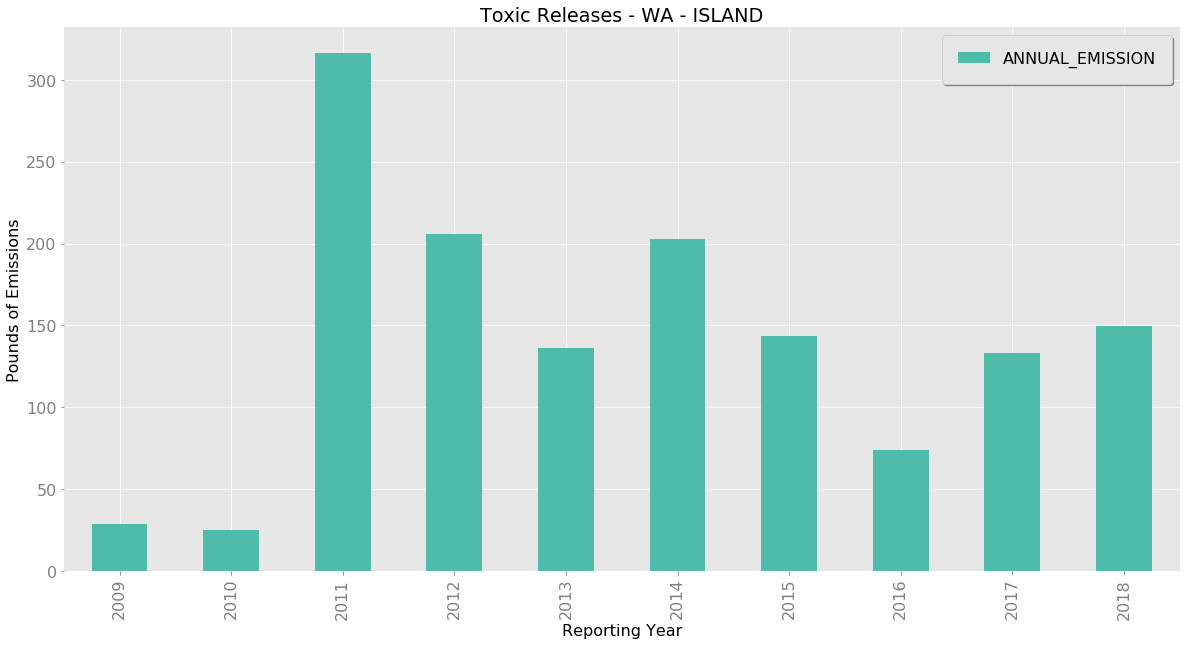

In [61]:
state = None
if ( state_widget ):
    state = state_widget.value
    
show_chart( program=program, region=region_selected, data=program_data, state=state )

### 13. Show the facilities in the region in this data set.

In [62]:
map_of_facilities = mapper(df=program_data, is_echo=False)
map_of_facilities

### 14. You may save the facility data for the selected EPA program and your region
This next cell lets you to save the data for facilities in this region monitored 
under the selected EPA program.

In [ ]:
if ( len( program_data ) > 0 ):
    filename = 'ECHO_EXPORTER-' + program.echo_type + '-' + str( region_selected )
    fullpath = filename+'.csv'
    my_prog_data.to_csv( fullpath ) 
    print( "Wrote "+filename+" to the Google Colab 'Files' menu as %s" %(fullpath))
else:
    print( "There is no facility data for this program and region." )

### If you'd like to look at another dimension of ECHO data for this region...
....return to the dropdown menu above and choose a different program/data type, run the database access code, and then chart and map it!

---

## Choose a specific facility
### 15. In the next few blocks of code, you can focus in on just one of these facilities in the region.
Run the below cell, then choose a facility from the dropdown that appears.

In [63]:
fac_series = echo_data["FAC_NAME"]
fac_widget = show_fac_widget( fac_series )

Dropdown(description='Facility Name:', layout=Layout(width='70%'), options=('5 CENTER WANT ADS', '7 ELEVEN #25…

### 16. The next cell filters the program-specific IDs to get just records for the selected facility.
Running this cell will create a dropdown list of the program data sets available specifically for this faciliity. Pick one and then run the second cell to view its contents.

In [64]:
fac_data = echo_data[echo_data["FAC_NAME"] == fac_widget.value]
fac_pgm_widget = show_fac_pgm_widget( fac_data=fac_data, data_sets=data_sets )

Dropdown(description='Data sets:', options=('RCRA Violations', 'RCRA Inspections', 'RCRA Enforcements', 'Combi…

### 17. Let's see the data for this facility

In [65]:
#fac_pgm_data = get_fac_pgm_data( fac_data, data_sets[ fac_pgm_widget.value ] )
fac_pgm_data = get_program_data( data_sets[ fac_pgm_widget.value ], fac_data )

if ( fac_pgm_data is None ):
    print( "There is no {} data for {} ".format( fac_pgm_widget.value, fac_widget.value ))
else:
    print( fac_pgm_data )

select * from `POLL_RPT_COMBINED_EMISSIONS`  where PGM_SYS_ACRNM = 'TRIS' and REGISTRY_ID in ('110064224227')
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20%2A%20from%20%60POLL_RPT_COMBINED_EMISSIONS%60%20%20where%20PGM_SYS_ACRNM%20%3D%20%27TRIS%27%20and%20REGISTRY_ID%20in%20%28%27110064224227%27%29
   REPORTING_YEAR PGM_SYS_ACRNM       PGM_SYS_ID  POLLUTANT_NAME  \
0            2017          TRIS  98277TCHNC584WT            Lead   
0            2016          TRIS  98277TCHNC584WT            Lead   
0            2014          TRIS  98277TCHNC584WT  Lead compounds   
0            2009          TRIS  98277TCHNC584WT  Lead compounds   
0            2012          TRIS  98277TCHNC584WT  Lead compounds   
0            2013          TRIS  98277TCHNC584WT  Lead compounds   
0            2011          TRIS  98277TCHNC584WT  Lead compounds   
0            2015          TRIS  98277TCHNC584WT  Lead compounds   
0            2010          TRIS  98277TCHNC584WT  Lead compounds   
0         

### 18. We can make a chart

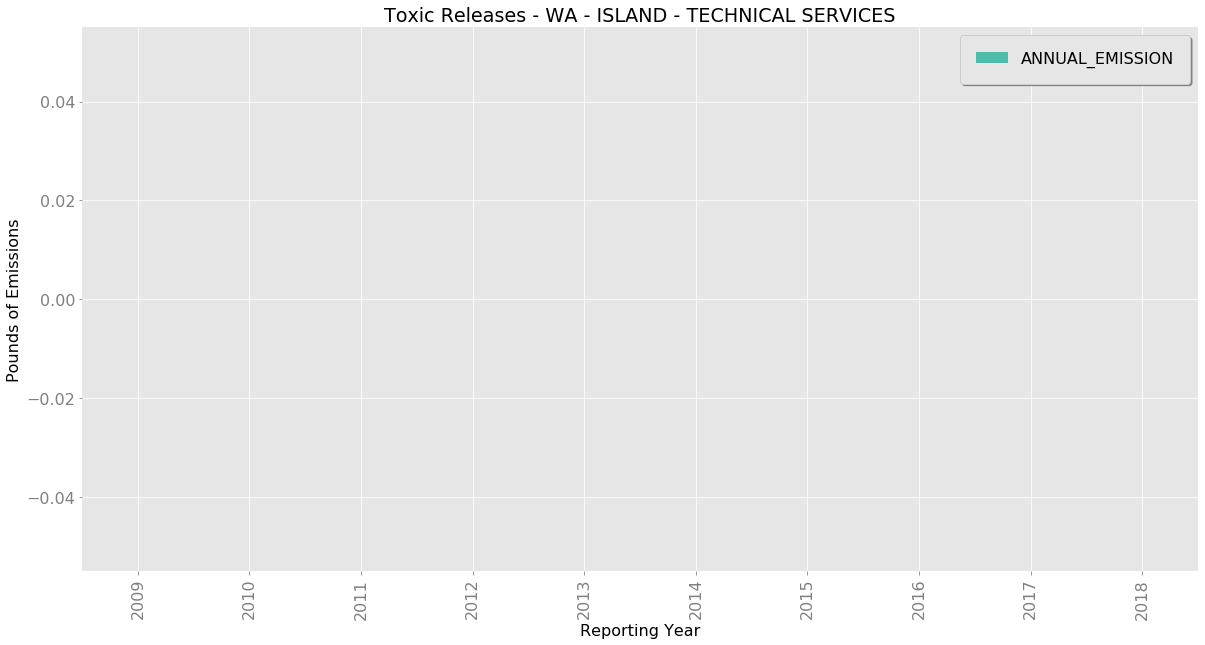

In [66]:
show_chart( program=data_sets[ fac_pgm_widget.value ], region=region_selected, 
           data=fac_pgm_data, state=state, fac_name=fac_widget.value )

### 19. This cell saves this facility's data for this program to your computer.
The next cell exports this data to your computer.  You can return to the dropdown to export additional data files.

_Note: When you click on [] in the cell, it may continue to show \*. That's to be expected! Check your Downloads folder and confirm that the spreadsheet was succesfully exported. Hit the square button (Interrupt Kernel) at the top of the page. You can now choose to export other data sets from the dropdown..._

In [45]:
# fac_pgm_data = add_fac_to_pgm_data( fac_pgm_data, fac_data )

filename = fac_pgm_widget.value + '-' + fac_widget.value + '.csv'
fac_pgm_data.to_csv( filename ) 

print( "Wrote "+filename)

Wrote Clean Water InspectionsCOUPEVILLE TOWN STP.csv


### Accessing your files
Click on the 'Files' tab in the menu on the left-hand side of the notebook (it looks like a folder). You may have to hit 'Refresh' if you don't see your file. Then, you can click on the ... next to your file and choose "Download". The CSV spreadsheet will download to wherever your browser usually saves files (e.g. Downloads folder)

### If you'd like to look at another dimension of ECHO data for this facility...
....return to the dropdown menu above and choose a different program/data type, then chart it!